In [10]:
import warnings
warnings.filterwarnings("ignore")

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 123
random.seed(seed)
np.random.seed(seed)

## Loading & Pre-processing the Images
We will load the images from the `keras.datasets.mnist` package, using the `load_data()` function. Keras ships with several datasets, like MNIST(Modified National Institute of Standards and Technology database), Fashion, CIFAR-10 etc., which we can leverage for learning ML techniques.

The following pre-processing steps will be applied:
* The image data (X's) will be converted to floats & scaled to values between 0.0 & 1.0
* The labels (y's) will be one-hot encoded to width of 10 (as we have 10 output classes corresponding to digits 0-9)
* The training set (`X_train, y_train`) will be shuffled & split into training & cross-validation sets using an 80:20 split - we have 60,000 training examples, which will be split into two sets of 48,000 and 12,000 images &amp; labels. 
* The images & label arrays will be appropriately reshaped - `images -> (num_samples, num_features)`, `labels -> (num_samples, num_classes)`
* We will also keep a copy of the test images & labels (i.e. of `X_test & y_test`) _before_ any preprocessing is applied. This is to help with data visualization of the _'original dataset'_.

In [11]:
def load_and_preprocess_data(debug=False):
    from keras.datasets.mnist import load_data
    from keras.utils import to_categorical
    
    (X_train, y_train), (X_test, y_test) = load_data()
    
    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

    # Following Andrew Ng's advise in his Structured ML course (deeplearning.ai), we will split
    # the test set into cross-val & test sets. Since we have 10,000 records in the test set,
    # we'll set aside 6000 for the cross-val and leave the remaining 4000 in the test set
    indexes = np.random.permutation(X_test.shape[0])
    X_test, y_test = X_test[indexes], y_test[indexes]
    
    X_val, y_val = X_test[:6000], y_test[:6000]
    X_test, y_test = X_test[6000:], y_test[6000:]
    # keep a copy of non-preprocessed test set aside for displaying images etc.
    test_images, test_labels = X_test.copy(), y_test.copy()
    
    # scale the images to between 0-1 & one-hot encode labels to 10 output classes 
    # corresponding to digits 0-9
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, 10) 
    y_val = to_categorical(y_val, 10)
    y_test = to_categorical(y_test, 10)
    
    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    print('After preprocessing: ')
    print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
    print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
    print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
    print(' - test_images.shape = {}, test_labels.shape = {}'.format(
        test_images.shape, test_labels.shape))    
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [12]:
def display_sample(sample_images, sample_labels, sample_predictions=None,
                   num_rows=5, num_cols=10, plot_title=None, fig_size=None):
    """ 
    display a random selection of images & corresponding labels, optionally with predictions 
    The display is laid out in a grid of num_rows x num_col cells.
    If sample_predictions are provided, then each cell's title displays the prediction (if it 
    matches actual value) else it displays actual value/prediction. 
    """
    assert sample_images.shape[0] == num_rows * num_cols
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows,num_cols,figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="gray")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("Num: %s" % sample_labels[image_index])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = \
                        (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = 'Num: %s' % true_label
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = 'Num: %s/%s' % (true_label, pred_label)
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None: f.suptitle(plot_title)
    
        plt.show()
        plt.close()

In [13]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)

Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
After preprocessing: 
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000, 10)
 - X_val.shape = (6000, 28, 28, 1), y_val.shape = (6000, 10)
 - X_test.shape = (4000, 28, 28, 1), y_test.shape = (4000, 10)
 - test_images.shape = (4000, 28, 28), test_labels.shape = (4000,)


Displaying a random sample of 50 images from dataset


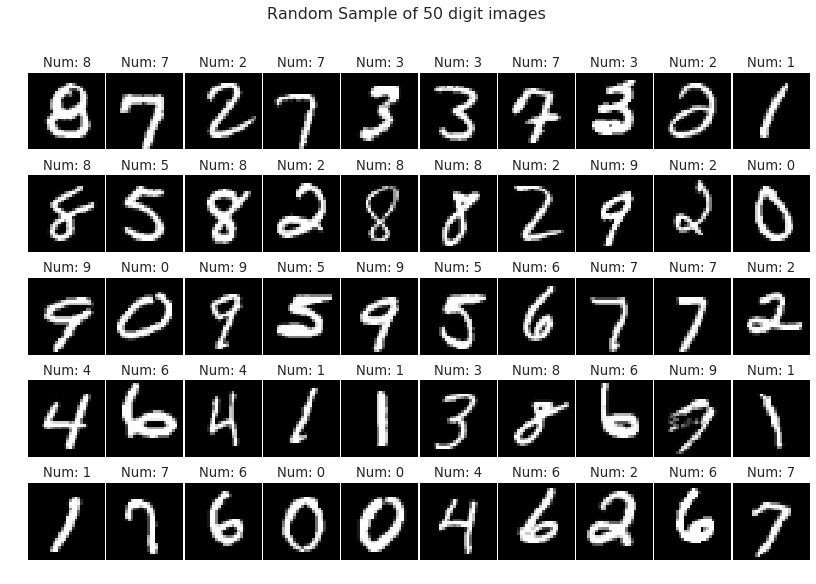

In [14]:
# display a random sample of 50 digits
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels = test_images[indexes], test_labels[indexes]
display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10, 
               plot_title="Random Sample of {} digit images".format(sample_size))

In [15]:
# set some globals, which we'll use across the remaining functions
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SHAPE, NUM_CLASSES = 28, 28, (28,28,1), 10
# training parameters
NUM_EPOCHS, BATCH_SIZE = 50, 128
# for loading & saving model state
KR_MODEL_NAME = 'kr_MNIST_cnn'

## Keras Implementation
We will develop model using Keras' Sequential API, which is much simpler to understand that the Functional API.

In [16]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
# import kr_helper_funcs as kru

# clear the Tensorflow backend to get rid of any spurious graphs
K.clear_session()

In [17]:
def build_keras_model():
    K.clear_session()
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
                    input_shape=IMAGE_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.45))
    # output is softmax for 10 classes
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [18]:
kr_model = build_keras_model()
print(kr_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                31370     
Total para

In [19]:
# train the model
history = kr_model.fit(X_train, y_train, epochs=35, batch_size=BATCH_SIZE, 
                       validation_data=(X_val, y_val))

Train on 60000 samples, validate on 6000 samples
Epoch 1/35
60000/60000 [==============================] - 238s 4ms/step - loss: 0.2794 - acc: 0.9150 - val_loss: 0.0719 - val_acc: 0.9773
Epoch 2/35
60000/60000 [==============================] - 242s 4ms/step - loss: 0.0846 - acc: 0.9735 - val_loss: 0.0414 - val_acc: 0.9862
Epoch 3/35
60000/60000 [==============================] - 241s 4ms/step - loss: 0.0641 - acc: 0.9804 - val_loss: 0.0348 - val_acc: 0.9873
Epoch 4/35
60000/60000 [==============================] - 251s 4ms/step - loss: 0.0537 - acc: 0.9836 - val_loss: 0.0287 - val_acc: 0.9903
Epoch 5/35
60000/60000 [==============================] - 240s 4ms/step - loss: 0.0462 - acc: 0.9858 - val_loss: 0.0300 - val_acc: 0.9910
Epoch 6/35
60000/60000 [==============================] - 241s 4ms/step - loss: 0.0407 - acc: 0.9872 - val_loss: 0.0279 - val_acc: 0.9905
Epoch 7/35
60000/60000 [==============================] - 246s 4ms/step - loss: 0.0375 - acc: 0.9878 - val_loss: 0.0281 - v

In [20]:
# display plots of loss & accuracies
# kru.show_plots(history.history)

In [21]:
# evaluate performance against train/cross-val & test data
print('Evaluating performance of Keras model:')
loss, acc = kr_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
print(' - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(' - Cross-validation dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(' - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

Evaluating performance of Keras model:
60000/60000 [==============================] - 76s 1ms/step
 - Training dataset: loss = 0.0023, accuracy = 0.9995
6000/6000 [==============================] - 7s 1ms/step
 - Cross-validation dataset: loss = 0.0241, accuracy = 0.9938
4000/4000 [==============================] - 5s 1ms/step
 - Test dataset: loss = 0.0282, accuracy = 0.9930


**Observations for Keras Model:**
* We get a `training accuracy = ~99.9%`, a `cross-validation accuracy = ~99%` and a `test accuracy = ~99%` with this model. 
* Our model is getting very good testing accuracy `~99%` and is not overfitting the data (training accuracy is not much different from cross-validation accuracies (as can be seen from both the plots).
* However, notice that the metrics flatten out after ~20-25 epochs, so we could limit training to these many epohs and get similar performance.

### Making Predictions with the Keras Model
Next we will run predictions with our Tensorflow model & view some random results.

In [22]:
# this is the ground truth (reverse one-hot encode of test data)
y_true = np.argmax(y_test, axis=1)
y_true[:30]

array([4, 2, 3, 8, 3, 3, 7, 8, 4, 0, 5, 2, 5, 3, 6, 0, 3, 1, 5, 4, 3, 9, 3,
       0, 2, 3, 8, 2, 0, 9])

In [23]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
y_pred[:30]

array([4, 2, 3, 8, 3, 3, 7, 8, 4, 0, 5, 2, 5, 3, 6, 0, 3, 1, 5, 4, 3, 9, 3,
       0, 2, 3, 8, 2, 0, 9])

In [24]:
# count of predictions &how many incorrect predictions overall??
len(y_pred), (y_pred != y_true).sum()

(4000, 28)

Displaying a random sample of 50 images from dataset


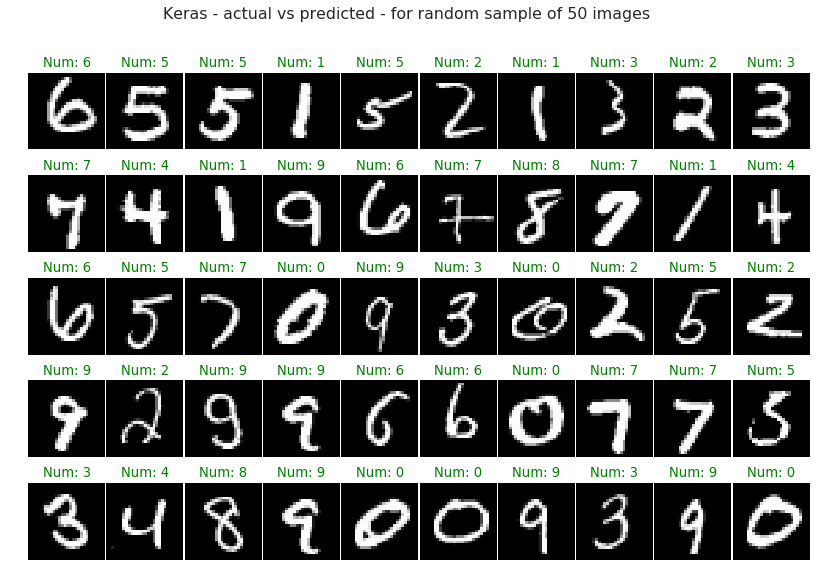

In [25]:
# display a random sample of 50 digits with predictions
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))

## Summary
* We were able to achieve very good performance with a CNN - better than our MLP, which was itself not that bad.
* CNN's are better suited for image classification that MLPs in general. 
* For the MNIST digits dataset, which is very simple, we get similar performance. For more complex image datasets we should see CNN's perform far better than MLPs

# <center> -- END -- </center>